# Setup


In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
Signals  = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 5/Signals.csv", header=None)
labels_int = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 5/labels_int.csv", names=['labels'], header=None)

In [5]:
#labels_int
Signals.head()

,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
0,-127,-162,-197,-229,-245,-254,-261,-265,-268,-268,...,36,19,8,0,-7,-12,-15,-18,-22,-21
1,128,157,189,226,250,257,262,265,268,269,...,-7,-5,-3,-2,-1,-1,0,0,1,2
2,56,73,85,93,100,107,113,117,118,117,...,19,18,16,14,12,12,12,13,14,15
3,16,17,17,19,20,21,21,21,19,16,...,-101,-104,-106,-104,-99,-91,-81,-64,-36,-20
4,519,619,723,827,914,956,955,934,920,900,...,1142,1144,1055,866,632,403,224,116,17,18


In [6]:
Labels = labels_int.replace([1,2],['A','N'])

In [7]:
#split data into normal and afib data for oversampling
afibX = Signals.loc[Labels['labels'] == 'A']
afibY = Labels.loc[Labels['labels'] == 'A']

normalX = Signals.loc[Labels['labels'] == 'N']
normalY = Labels.loc[Labels['labels'] == 'N']

# Data Processing


In [ ]:
from sklearn.model_selection import train_test_split

#split data into training and testing data
XTrainA, XTestA, YTrainA, YTestA = train_test_split(afibX, afibY, test_size=0.1, random_state=42)
XTrainN, XTestN, YTrainN, YTestN = train_test_split(normalX, normalY, test_size=0.1, random_state=42)

In [ ]:
#To achieve the same number of signals in each class, use the first 4438 Normal signals, and then use repmat to repeat the first 634 AFib signals seven times.
XTrain = pd.concat([XTrainA[:634], XTrainA[:634], XTrainA[:634], XTrainA[:634], XTrainA[:634], XTrainA[:634], XTrainA[:634], XTrainN[:4438]], ignore_index=True)
YTrain = pd.concat([YTrainA[:634], YTrainA[:634], YTrainA[:634], YTrainA[:634], YTrainA[:634], YTrainA[:634], YTrainA[:634], YTrainN[:4438]], ignore_index=True)

#Use the first 490 Normal signals, and then use repmat to repeat the first 70 AFib signals seven times
XTest = pd.concat([XTestA[:70], XTestA[:70], XTestA[:70], XTestA[:70], XTestA[:70], XTestA[:70], XTestA[:70], XTestN[:490]], ignore_index=True)
YTest = pd.concat([YTestA[:70], YTestA[:70], YTestA[:70], YTestA[:70], YTestA[:70], YTestA[:70], YTestA[:70], YTestN[:490]], ignore_index=True)


In [ ]:
#check that even amounts of afib and normal data for training and testing
YTrain['labels'].value_counts()

A    4438
N    4438
Name: labels, dtype: int64

In [ ]:
YTest['labels'].value_counts()

A    490
N    490
Name: labels, dtype: int64

# LSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM 
from keras.layers import Bidirectional, Activation
from keras import optimizers
import tensorflow as tf

# x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)

# N=9000 timesteps
# window_size=100
# Num_samples = 8876
# LSTM takes (N - window_size, window_size, num_features)

## reshape data


In [ ]:
#change YTrain to categorical
Y_cat = YTrain.replace(['A','N'], [0,1]).to_numpy()
y_final = tf.keras.utils.to_categorical(Y_cat)
print(y_final.shape)
y_final

(8876, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
#change YTest to categorical
Y_cat_test = YTest.replace(['A','N'], [0,1]).to_numpy()
y_final_test = tf.keras.utils.to_categorical(Y_cat_test)
print(y_final_test.shape)
y_final_test

(980, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
#This data can be framed as 8876 sample with 9000 time steps and 1 feature.
XTrain_reshaped = XTrain.to_numpy().reshape((8876,9000,1))
XTest_reshaped = XTest.to_numpy().reshape((980,9000,1))


XTrain_reshaped.shape
XTest_reshaped.shape

(980, 9000, 1)

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(9000, 1)))
model.add(Dense(2, activation='softmax'))

# opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [ ]:
y_final.shape

(8876, 2)

In [ ]:
model.fit(XTrain_reshaped, y_final, epochs=4, batch_size=100)


Epoch 1/4
89/89 [==============================] - 100s 1s/step - loss: 0.6977 - categorical_accuracy: 0.5359
Epoch 2/4
89/89 [==============================] - 98s 1s/step - loss: 0.6776 - categorical_accuracy: 0.5714
Epoch 3/4
89/89 [==============================] - 97s 1s/step - loss: 0.6734 - categorical_accuracy: 0.5831
Epoch 4/4
89/89 [==============================] - 97s 1s/step - loss: 0.6642 - categorical_accuracy: 0.5994


In [ ]:
ypred=model.predict(XTest_reshaped)

In [ ]:
ypred

array([[0.45397386, 0.5460262 ],
       [0.32444957, 0.67555046],
       [0.5839057 , 0.4160943 ],
       ...,
       [0.6220985 , 0.37790146],
       [0.4746678 , 0.5253322 ],
       [0.5799249 , 0.42007512]], dtype=float32)

## Original Bidirection LSTM Model

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=False), input_shape=(9000,1)))
model.add(Dense(2, activation='softmax'))

# opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(XTrain_reshaped, y_final, epochs=4, batch_size=100)


Epoch 1/4
89/89 [==============================] - 198s 2s/step - loss: 0.6826 - categorical_accuracy: 0.5594
Epoch 2/4
89/89 [==============================] - 194s 2s/step - loss: 0.6603 - categorical_accuracy: 0.5993
Epoch 3/4
89/89 [==============================] - 194s 2s/step - loss: 0.6402 - categorical_accuracy: 0.6300
Epoch 4/4
89/89 [==============================] - 194s 2s/step - loss: 0.6178 - categorical_accuracy: 0.6578


### Original Bidirection LSTM Model - Accuracy on TRAIN Data

In [ ]:
ypred_train=model.predict(XTrain_reshaped)

In [ ]:
#choose category with highest likelihood and turn answers into 1 feature array 
ypred_train_array = np.argmax(ypred_train, axis=1)
yfinal_train_array = np.argmax(y_final, axis=1)



labels_dict = {0:'A', 1:'N'}

#convert predictions on training back into letters
ypred_label_letters = [labels_dict[letter] for letter in ypred_train_array]

#convert training labels back into letters
ytrain_label_letters = [labels_dict[letter] for letter in yfinal_train_array]



ypred_label_letters = np.array(ypred_label_letters).flatten()
ytrain_label_letters = np.array(ytrain_label_letters).flatten()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(ytrain_label_letters, ypred_label_letters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['A', 'N'])

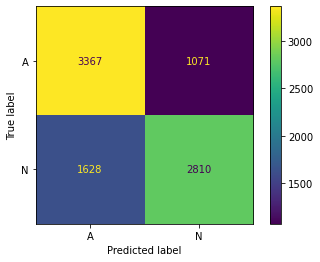

In [ ]:
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy of LSTM prediction:", accuracy_score(ytrain_label_letters, ypred_label_letters))

accuracy of LSTM prediction: 0.6959215863001352


### Original Bidirection LSTM Model - Accuracy on TEST Data

In [ ]:
ypred_test = model.predict(XTest_reshaped)

In [ ]:
#choose category with highest likelihood and turn answers into 1 feature array 
ypred_test_array = np.argmax(ypred_test, axis=1)
yfinal_test_array = np.argmax(y_final_test, axis=1)



labels_dict = {0:'A', 1:'N'}

#convert predictions on training back into letters
ypred_label_test_letters = [labels_dict[letter] for letter in ypred_test_array]

#convert training labels back into letters
ytest_label_letters = [labels_dict[letter] for letter in yfinal_test_array]



ypred_label_test_letters = np.array(ypred_label_test_letters).flatten()
ytest_label_letters = np.array(ytest_label_letters).flatten()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(ytest_label_letters, ypred_label_test_letters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['A', 'N'])

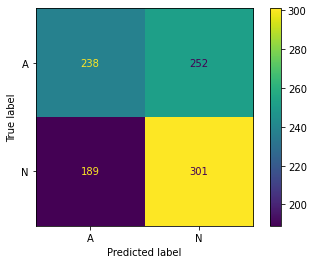

In [ ]:
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy of LSTM prediction:", accuracy_score(ytest_label_letters, ypred_label_test_letters))

accuracy of LSTM prediction: 0.55


# Improve model

## Feature Extraction

# Final Improved Model

In [ ]:
XTrainSD  = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 5/XTrainSD.csv", header=None)
YTrainSD = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 5/YTrainSD.csv", names=['labels'], header=None)

XTestSD  = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 5/XTestSD.csv", header=None)
YTestSD = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 5/YTestSD.csv", names=['labels'], header=None)

data was already repadded and split evenly in mtalab preprocessing

## reshape data


In [ ]:
#change YTrain to categorical
Y_cat = YTrainSD.replace([1,2], [0,1]).to_numpy() #change labels from 1's and 2's to 0's and 1's (consistent with A-N before)
y_final = tf.keras.utils.to_categorical(Y_cat)
print(y_final.shape)
y_final

(8876, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
#change YTest to categorical
Y_cat_test = YTestSD.replace([1,2], [0,1]).to_numpy() #change labels from 1's and 2's to 0's and 1's (consistent with A-N before)
y_final_test = tf.keras.utils.to_categorical(Y_cat_test)
print(y_final_test.shape)
y_final_test

(980, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
#This data can be framed as 8876 sample with 9000 time steps and 1 feature.
XTrain_reshaped = XTrainSD.to_numpy().reshape((8876,255,2))
XTest_reshaped = XTestSD.to_numpy().reshape((980,255,2))

XTrain_reshaped.shape
XTest_reshaped.shape

(980, 255, 2)

## Original Bidirection LSTM Model

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=False), input_shape=(255,2)))
model.add(Dense(2, activation='softmax'))

# opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(XTrain_reshaped, y_final, epochs=10, batch_size=150)


Epoch 1/10
60/60 [==============================] - 10s 101ms/step - loss: 0.6176 - categorical_accuracy: 0.6725
Epoch 2/10
60/60 [==============================] - 6s 99ms/step - loss: 0.6007 - categorical_accuracy: 0.6888
Epoch 3/10
60/60 [==============================] - 6s 98ms/step - loss: 0.6023 - categorical_accuracy: 0.6845
Epoch 4/10
60/60 [==============================] - 6s 99ms/step - loss: 0.6127 - categorical_accuracy: 0.6939
Epoch 5/10
60/60 [==============================] - 6s 98ms/step - loss: 0.5813 - categorical_accuracy: 0.7012
Epoch 6/10
60/60 [==============================] - 6s 98ms/step - loss: 0.5727 - categorical_accuracy: 0.7124
Epoch 7/10
60/60 [==============================] - 6s 98ms/step - loss: 0.5465 - categorical_accuracy: 0.7161
Epoch 8/10
60/60 [==============================] - 6s 99ms/step - loss: 0.5216 - categorical_accuracy: 0.7413
Epoch 9/10
60/60 [==============================] - 6s 99ms/step - loss: 0.5000 - categorical_accuracy: 0.7608

### Original Bidirection LSTM Model - Accuracy on TRAIN Data

In [ ]:
ypred_train=model.predict(XTrain_reshaped)

In [ ]:
#choose category with highest likelihood and turn answers into 1 feature array 
ypred_train_array = np.argmax(ypred_train, axis=1)
yfinal_train_array = np.argmax(y_final, axis=1)



labels_dict = {0:'A', 1:'N'}

#convert predictions on training back into letters
ypred_label_letters = [labels_dict[letter] for letter in ypred_train_array]

#convert training labels back into letters
ytrain_label_letters = [labels_dict[letter] for letter in yfinal_train_array]



ypred_label_letters = np.array(ypred_label_letters).flatten()
ytrain_label_letters = np.array(ytrain_label_letters).flatten()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(ytrain_label_letters, ypred_label_letters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['A', 'N'])

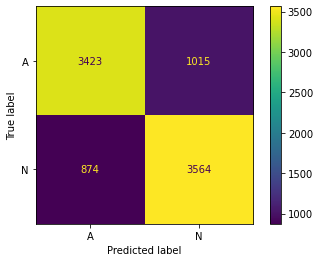

In [ ]:
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy of LSTM prediction:", accuracy_score(ytrain_label_letters, ypred_label_letters))

accuracy of LSTM prediction: 0.7871789094186571


### Original Bidirection LSTM Model - Accuracy on TEST Data

In [ ]:
ypred_test = model.predict(XTest_reshaped)

In [ ]:
#choose category with highest likelihood and turn answers into 1 feature array 
ypred_test_array = np.argmax(ypred_test, axis=1)
yfinal_test_array = np.argmax(y_final_test, axis=1)



labels_dict = {0:'A', 1:'N'}

#convert predictions on training back into letters
ypred_label_test_letters = [labels_dict[letter] for letter in ypred_test_array]

#convert training labels back into letters
ytest_label_letters = [labels_dict[letter] for letter in yfinal_test_array]



ypred_label_test_letters = np.array(ypred_label_test_letters).flatten()
ytest_label_letters = np.array(ytest_label_letters).flatten()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(ytest_label_letters, ypred_label_test_letters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['A', 'N'])

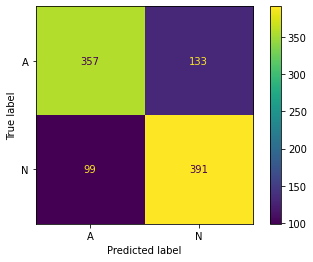

In [ ]:
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy of LSTM prediction:", accuracy_score(ytest_label_letters, ypred_label_test_letters))

accuracy of LSTM prediction: 0.763265306122449
